In [54]:
#!pip install utils
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import transforms
from datetime import datetime
import random, math
import numpy as np
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from torch.utils.data import DataLoader
import json
from sklearn.metrics import confusion_matrix
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('dajee GPU')
else:
    device = torch.device('cpu')
    print('nooo la poliziaaa')

print('Using PyTorch version:', torch.__version__, ' Device:', device)
print('GPU name:', torch.cuda.get_device_name(0))
print('libreries okay...')

dajee GPU
Using PyTorch version: 2.7.0+cu118  Device: cuda
GPU name: NVIDIA GeForce RTX 2060
libreries okay...


In [62]:

config = {
    'DATA': {
        'ROOT': r'C:\Users\valer\OneDrive\Desktop\Progetto',
        'JSON': r'C:\Users\valer\OneDrive\Desktop\Progetto\NEW_JSON',
        'TRAIN_SUBSET': 'train',
        'EVAL_SUBSET': 'val',
        'RESIZE': 512, #512
        'NUM_WORKERS': 0,
        'NUM_CLASSES': 5,
        'IGNORE_INDEX': -1,
        'CLASSES_NAME': ['Impervious', 'Agriculture', 'Forest', 'Soil', 'Water']
    },
    'TRAINING': {
        'EPOCHS': 2,
        'BATCH_SIZE': 4,
        'LR': 0.0001,
        'LR_USE_DECAY': False,
        'WEIGHT_DECAY': 0,
    },
    'EVALUATION': {
        'BATCH_SIZE': 1
    },
    'LOSS': {
        'TYPE': 'cross-entropy',
        'TOPK': 1.0,
        'IGNORE_INDEX': -1
    }
}

In [56]:
class DynamicEarthNet(Dataset):
    def __init__(self, root, mode, crop_size=512, num_classes=5, ignore_index=-1):
        self.root = root
        self.mode = mode
        self.crop_size = crop_size
        self.num_classes = num_classes
        self.ignore_index = ignore_index

        self.mean = [1021.3123569285428, 903.536967115049, 666.9043876683271, 2610.930053977613]
        self.std = [991.6890141834742, 778.5736897721159, 663.9331094805594, 1052.519845034094]

        self.files, self.labels = self._load_file_list()

        # Setup delle trasformazioni con Albumentations
        if self.mode == "train":
            self.transform = A.Compose([
                # A.RandomCrop(width=crop_size, height=crop_size),
                A.Resize(config['DATA']['RESIZE'], config['DATA']['RESIZE']),
                # A.Resize(512, 512),
                A.Normalize(mean=self.mean, std=self.std, max_pixel_value=1.0),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                ToTensorV2(transpose_mask=True)
            ])
        else:  # val o test
            self.transform = A.Compose([
                # A.CenterCrop(width=crop_size, height=crop_size),
                A.Resize(config['DATA']['RESIZE'], config['DATA']['RESIZE']),
                # A.Resize(512, 512),
                A.Normalize(mean=self.mean, std=self.std, max_pixel_value=1.0),
                ToTensorV2(transpose_mask=True)
            ])

    def _load_file_list(self):
        txt_path = os.path.join(self.root, f"{self.mode}.txt")
        with open(txt_path, "r") as f:
            lines = [line.strip().split() for line in f.readlines()]
        files, labels = zip(*lines)
        return list(files), list(labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        # Carica immagine multispettrale
        img_path = os.path.join(self.root, self.files[index])
        with rasterio.open(img_path) as img:
            red = img.read(3)
            green = img.read(2)
            blue = img.read(1)
            nir = img.read(4)
            image = np.dstack((red, green, blue, nir)).astype(np.float32)

            ndvi = (nir - red) / (nir + red + 1e-6)
            ndwi = (green - nir) / (green + nir + 1e-6)

        # Carica maschera
        label_path = os.path.join(self.root, self.labels[index])
        with rasterio.open(label_path) as lbl:
            label = lbl.read()  # (num_classes+1, H, W)

            wetlands_channel = 3

            new_index = 0
            mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int32)
            for i in range(label.shape[0]):
                if i == wetlands_channel:
                    continue  # Salta il canale della classe da escludere
                elif i == label.shape[0] - 1:
                    mask[label[i, :, :] == 255] = self.ignore_index
                else:
                    mask[label[i, :, :] == 255] = new_index
                    new_index += 1

        # Applica le trasformazioni
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"]

        image = image[[0, 1, 2], :, :]

        return image, mask.long()


In [57]:
data_config = config['DATA']

train_data = DynamicEarthNet(root=data_config['ROOT'], mode=data_config['TRAIN_SUBSET'],
                            crop_size=data_config['RESIZE'], num_classes=data_config['NUM_CLASSES'],
                            ignore_index=data_config['IGNORE_INDEX'])

val_data = DynamicEarthNet(root=data_config['ROOT'], mode=data_config['EVAL_SUBSET'],
                          crop_size=data_config['RESIZE'], num_classes=data_config['NUM_CLASSES'],
                          ignore_index=data_config['IGNORE_INDEX'])


train_loader = torch.utils.data.DataLoader(train_data, batch_size=config['TRAINING']['BATCH_SIZE'],
                                            shuffle=True, num_workers=data_config['NUM_WORKERS'],
                                            pin_memory=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=config['EVALUATION']['BATCH_SIZE'],
                                          shuffle=False, num_workers=data_config['NUM_WORKERS'],
                                          pin_memory=True)

In [58]:
def get_data_loaders():

  data_config = config['DATA']

  train_data = DynamicEarthNet(root=data_config['ROOT'], mode=data_config['TRAIN_SUBSET'],
                            crop_size=data_config['RESIZE'], num_classes=data_config['NUM_CLASSES'],
                            ignore_index=data_config['IGNORE_INDEX'])

  val_data = DynamicEarthNet(root=data_config['ROOT'], mode=data_config['EVAL_SUBSET'],
                            crop_size=data_config['RESIZE'], num_classes=data_config['NUM_CLASSES'],
                            ignore_index=data_config['IGNORE_INDEX'])

  test_data = DynamicEarthNet(root=data_config['ROOT'], mode=data_config['EVAL_SUBSET'],
                              crop_size=data_config['RESIZE'], num_classes=data_config['NUM_CLASSES'],
                              ignore_index=data_config['IGNORE_INDEX'])

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=config['TRAINING']['BATCH_SIZE'],
                                            shuffle=True, num_workers=data_config['NUM_WORKERS'],
                                            )

  val_loader = torch.utils.data.DataLoader(val_data, batch_size=config['EVALUATION']['BATCH_SIZE'],
                                            shuffle=False, num_workers=data_config['NUM_WORKERS'],
                                            )

  test_loader = torch.utils.data.DataLoader(test_data, batch_size=config['EVALUATION']['BATCH_SIZE'],
                                            shuffle=False, num_workers=data_config['NUM_WORKERS'],
                                            )

  return train_loader, val_loader, test_loader

In [59]:
print('trainset len:', len(train_data))
print('validation len:', len(val_data))
for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    print("Mean per channel after transform:", images.mean(dim=[0, 2, 3]))
    print("Std per channel after transform: ", images.std(dim=[0, 2, 3]))
    print('--------------------------------------------------------------')
    break

trainset len: 1080
validation len: 120
torch.Size([4, 3, 512, 512])
torch.Size([4, 512, 512])
Mean per channel after transform: tensor([0.7138, 0.5745, 0.3915])
Std per channel after transform:  tensor([1.4429, 1.2659, 0.8922])
--------------------------------------------------------------


In [60]:
unique_classes = set()

for i in tqdm(range(len(train_data)), desc="Scanning masks"):
    _, mask = train_data[i]
    unique_classes.update(mask.unique().tolist())

print("\nClassi presenti nelle maschere:", unique_classes)

Scanning masks: 100%|██████████████████████████████████████████████████████████████| 1080/1080 [02:11<00:00,  8.24it/s]


Classi presenti nelle maschere: {0, 1, 2, 3, 4, -1}


In [63]:
def plot_class_distribution(dataset, title="Class Distribution"):
    counts = np.zeros(5)  # 5 classi attive (0-4)

    for _, mask in tqdm(dataset, desc="Analisi classi"):
        mask_np = mask.numpy() if torch.is_tensor(mask) else mask
        valid_mask = (mask_np != -1) & (mask_np < 5)
        unique, counts_batch = np.unique(mask_np[valid_mask], return_counts=True)

        for u, c in zip(unique, counts_batch):
            counts[u] += c

    class_names = config['DATA']['CLASSES_NAME']

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=class_names, y=counts, hue=class_names, palette="viridis", legend=False)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():,.0f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points')

    plt.title(title)
    plt.xlabel("Classi")
    plt.ylabel("Numero di pixel")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return counts #/ counts.sum() #così è in percentuale

Analisi classi: 100%|██████████████████████████████████████████████████████████████| 1080/1080 [02:10<00:00,  8.27it/s]


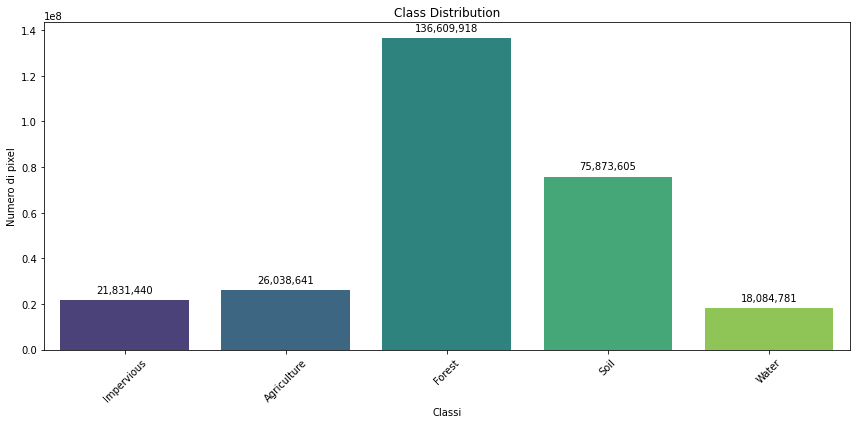

Distribuzione: [2.18314400e+07 2.60386410e+07 1.36609918e+08 7.58736050e+07
 1.80847810e+07] Percentuale: [ 7.84067182  9.35167075 49.0628898  27.24969296  6.49507466]


In [64]:
class_dist = plot_class_distribution(train_loader.dataset)
print('Distribuzione:', class_dist, 'Percentuale:', class_dist/class_dist.sum()*100)

In [65]:
def visualize_batch(images, masks, class_colors, class_names=None, ignore_value=-1, max_items=4):
    B = min(images.shape[0], max_items)
    fig, axs = plt.subplots(2, B, figsize=(B * 4, 8))

    for i in range(B):
        # Visualizza immagine
        img = images[i].cpu().numpy()
        img_rgb = img[[0, 1, 2], :, :]  # RGB
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  # (H, W, 3)
        vmin, vmax = np.percentile(img_rgb, (5, 95))
        img_rgb = np.clip(img_rgb, vmin, vmax)
        img_rgb = ((img_rgb - vmin) / (vmax - vmin + 1e-6) * 255).astype(np.uint8)
        axs[0, i].imshow(img_rgb)
        axs[0, i].set_title("Image")
        axs[0, i].axis("off")

        # Visualizza maschera con colori
        mask = masks[i].cpu().numpy()
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for j, color in enumerate(class_colors):
            color_mask[mask == j] = color
        if ignore_value is not None:
            color_mask[mask == ignore_value] = [0, 0, 0]  # nero per ignore_index

        axs[1, i].imshow(color_mask)
        axs[1, i].set_title("Mask")
        axs[1, i].axis("off")

    # --- Aggiungi legenda ---
    legend_elements = []
    for i, color in enumerate(class_colors):
        label = class_names[i] if class_names else f"Class {i}"
        patch = mpatches.Patch(color=np.array(color)/255.0, label=label)
        legend_elements.append(patch)

    if ignore_value is not None:
        legend_elements.append(mpatches.Patch(color='black', label=f"Ignore ({ignore_value})"))

    fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), fontsize=10)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # lascia spazio per la legenda sotto
    plt.show()


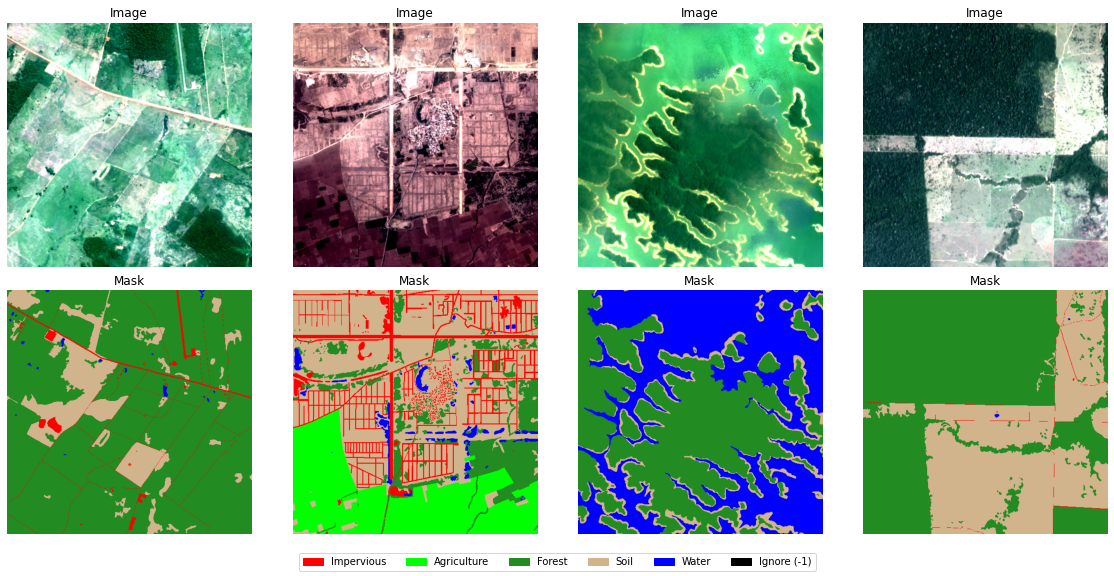

In [78]:

images, masks = next(iter(train_loader))

# Colori leggibili per le 5 classi (wetlands e snow/ice ignorate)
class_colors = [
    [255, 0, 0],      # Impervious
    [0, 255, 0],      # Agriculture
    [34, 139, 34],    # Forest
    # [0, 255, 255],      # Wetlands
    [210, 180, 140],  # Soil
    [0, 0, 255],      # Water
]
class_names = config['DATA']['CLASSES_NAME']

visualize_batch(images, masks, class_colors, class_names)

In [80]:
# avevo trovato Distribuzione: [ 5192434.   6508722.     34149714.  18974517.  4522445.]
# (nel train set)              [Impervious, Agriculture,  Forest,     Soil,       Water]

# adesso ho: [2.18314400e+07, 2.60386410e+07, 1.36609918e+08, 7.58736050e+07, 1.80847810e+07]

# class_counts = np.array([5192434, 6508722, 34149714, 18974517, 4522445], dtype=np.float32)
class_counts = np.array([2.18314400e+07, 2.60386410e+07, 1.36609918e+08, 7.58736050e+07, 1.80847810e+07])

total = class_counts.sum()
class_freq = class_counts / total
class_weights = 1.0 / class_freq
class_weights = class_weights / class_weights.mean()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights_tensor)
# risultato ottenuto: Class weights: tensor([1.4830, 1.1831, 0.2255, 0.4058, 1.7027], device='cuda:0')
# Quindi pesano di più le classi meno presenti come Water, Impervius e Agricolture, mentre Forest e Soil pesano poco :)

# adesso ho Class weights: tensor([1.4314, 1.2001, 0.2287, 0.4119, 1.7279], device='cuda:0')

Class weights: tensor([1.4314, 1.2001, 0.2287, 0.4119, 1.7279], device='cuda:0')


In [81]:
num_classes = config['DATA']['NUM_CLASSES']

def build_model():
    model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)  # Ho modificato l'ultimo layer per avere in output le 5 classi (senza ice e wetlands)
    return model.to(device)

In [82]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-1)

In [83]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print()
    return total_loss / len(loader)

In [84]:
def evaluate(model, loader, criterion, device, num_classes=config['DATA']['NUM_CLASSES']):
    model.eval()
    total_loss = 0.0
    cm = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            valid = masks_np != -1

            cm += confusion_matrix(masks_np[valid], preds_np[valid], labels=range(num_classes))

    print()
    iou = np.diag(cm) / (cm.sum(1) + cm.sum(0) - np.diag(cm) + 1e-9)
    return {
        'loss': total_loss / len(loader),
        'miou': np.nanmean(iou),
        'iou_per_class': iou.tolist(),
        'confusion_matrix': cm.tolist()
    }

In [85]:
def train_model(combination, device, num_epochs):

    train_loader, val_loader, _ = get_data_loaders()
    model = build_model().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=combination['lr'], weight_decay=combination['weight_decay']) if combination['optimizer'] == 'adam' else \
            torch.optim.SGD(model.parameters(), lr=combination['lr'], momentum=0.9)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    criterion = torch.nn.CrossEntropyLoss(
        weight=class_weights_tensor,
        ignore_index=-1
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'val_miou': [], 'val_iou': [],
        'combination': combination
    }

    best_miou = 0.0
    for epoch in range(num_epochs):

        print('-----------------------------------------------------------------------------------')
        print(f"Epoch {epoch+1}/{num_epochs}")
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)

        # Validation
        val_metrics = evaluate(model, val_loader, criterion, device)
        history['val_loss'].append(val_metrics['loss'])
        history['val_miou'].append(val_metrics['miou'])
        history['val_iou'].append(val_metrics['iou_per_class'])

        # Update scheduler
        scheduler.step(val_metrics['miou'])

        # Save best model
        if val_metrics['miou'] > best_miou:
            best_miou = val_metrics['miou']
            torch.save(model.state_dict(), os.path.join(json_path, f"best_model_{combination['id']}.pth"))

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val mIoU: {val_metrics['miou']:.4f}")

    return model, history

In [86]:
def hyperparameter_search(device, num_trials, num_epochs):
    search_space = {
        'lr': [1e-4, 5e-5, 1e-3],
        'batch_size': [8, 16, 32],
        'weight_decay': [0, 1e-4, 1e-3],
        'optimizer': ["adam", "sgd"],
        'resize': [224, 256],
        'augmentations': ["HorizontalFlip", "RandomRotate90", "VerticalFlip"],
    }

    results = {
        'best_miou': 0.0,
        'best_config': None,
        'trials': []
    }

    for trial in range(num_trials):
        combination = {
            'lr': np.random.choice(search_space['lr']),
            'batch_size': np.random.choice(search_space['batch_size']),
            'weight_decay': np.random.choice(search_space['weight_decay']),
            'optimizer': np.random.choice(search_space['optimizer']),
            'resize': np.random.choice(search_space['resize']),
            'augmentations': search_space['augmentations'],
            'num_workers': 0,
            'id': f"trial_{trial+1}"
        }

        con_strong_aug = {
            'lr': 1e-3,
            'batch_size': 16,
            'weight_decay': 0,
            'optimizer': 'adam',
            'resize': 256,
            'augmentations': ["HorizontalFlip", "VerticalFlip", "RandomRotate90"],
            'num_workers': 0,
            'id': f"trial_{trial+1}"
      }

        combination = con_strong_aug

        print(f"\nTrial {trial+1}/{num_trials}")
        print(json.dumps(combination, indent=2))

        model, history = train_model(combination, device, num_epochs)

        # Save results
        trial_data = {
            'combination': combination,
            'best_miou': max(history['val_miou']),
            'final_miou': history['val_miou'][-1],
            'val_miou': history['val_miou'],
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_iou': history['val_iou'],
        }
        results['trials'].append(trial_data)

        # Update best results
        if trial_data['final_miou'] > results['best_miou']:
            results['best_miou'] = trial_data['final_miou']
            results['best_config'] = combination

        # Save incremental results
        with open(os.path.join(json_path, 'HP_SEARCH.json'), 'w') as f:
            json.dump(results, f, indent=2)

    return results

In [87]:
def plot_results(history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title("Loss Curves")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['val_miou'], marker='o')
    plt.title("Validation mIoU")
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

json_path = config['DATA']['JSON']

search_results = hyperparameter_search(device, num_trials=1, num_epochs=4)

with open(os.path.join(json_path, 'FINAL_RESULT.json'), 'w') as f:
    json.dump(search_results, f, indent=2)

device: cuda

Trial 1/1
{
  "lr": 0.001,
  "batch_size": 16,
  "weight_decay": 0,
  "optimizer": "adam",
  "resize": 256,
  "augmentations": [
    "HorizontalFlip",
    "VerticalFlip",
    "RandomRotate90"
  ],
  "num_workers": 0,
  "id": "trial_1"
}
-----------------------------------------------------------------------------------
Epoch 1/4


Training: 100%|██████████████████████████████████████████████████████████████████████| 270/270 [02:35<00:00,  1.73it/s]


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 120/120 [00:20<00:00,  5.80it/s]


Train Loss: 1.1751 | Val Loss: 1.5445
Val mIoU: 0.3092
-----------------------------------------------------------------------------------
Epoch 2/4


Training: 100%|██████████████████████████████████████████████████████████████████████| 270/270 [02:39<00:00,  1.69it/s]


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 120/120 [00:20<00:00,  5.72it/s]


Train Loss: 0.9428 | Val Loss: 1.4945
Val mIoU: 0.3646
-----------------------------------------------------------------------------------
Epoch 3/4


Training: 100%|██████████████████████████████████████████████████████████████████████| 270/270 [02:36<00:00,  1.73it/s]


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 120/120 [00:21<00:00,  5.62it/s]


Train Loss: 0.8520 | Val Loss: 2.0659
Val mIoU: 0.3292
-----------------------------------------------------------------------------------
Epoch 4/4


Training: 100%|██████████████████████████████████████████████████████████████████████| 270/270 [02:37<00:00,  1.72it/s]


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 120/120 [00:20<00:00,  5.82it/s]

Train Loss: 0.8462 | Val Loss: 2.2734
Val mIoU: 0.2241


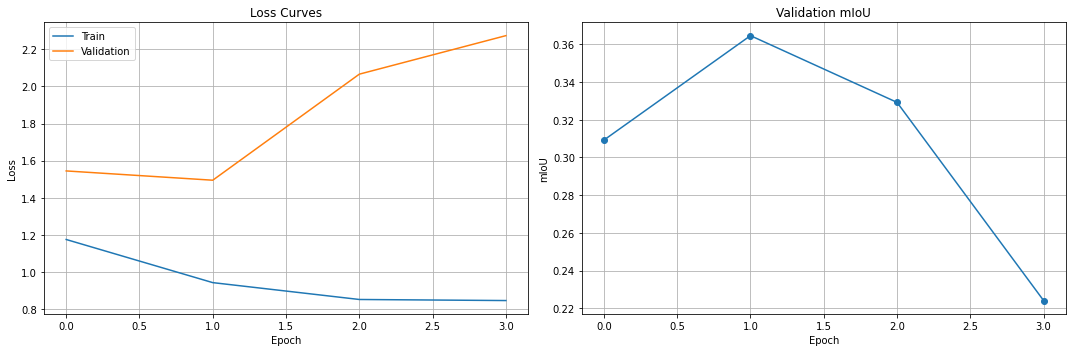

In [89]:
best_trial = max(search_results['trials'], key=lambda x: x['best_miou'])
plot_results(best_trial)

In [90]:
print(best_trial.items())
print(best_trial['val_miou'])

dict_items([('combination', {'lr': 0.001, 'batch_size': 16, 'weight_decay': 0, 'optimizer': 'adam', 'resize': 256, 'augmentations': ['HorizontalFlip', 'VerticalFlip', 'RandomRotate90'], 'num_workers': 0, 'id': 'trial_1'}), ('best_miou', 0.3645521828833707), ('final_miou', 0.22414387709946454), ('val_miou', [0.30919950722135814, 0.3645521828833707, 0.3291827589459385, 0.22414387709946454]), ('train_loss', [1.175140416622162, 0.942796802189615, 0.8519645983422244, 0.8461897455983691]), ('val_loss', [1.5445484676708778, 1.494535751392444, 2.0659220445901156, 2.2734329010049503]), ('val_iou', [[0.164908222560628, 0.135637525224552, 0.26485439325065535, 0.41854167597607767, 0.5620557190948777], [0.16372721048476702, 0.10176257234499957, 0.43399735925578337, 0.432293951795762, 0.6909798205355416], [0.14273822452568513, 0.0320990100453613, 0.41539982020548993, 0.4025791963475895, 0.6530975436055666], [0.17564662199133765, 0.056300761545548625, 0.3713358280453842, 0.42688058107131177, 0.090555

In [91]:
best_model = build_model().to(device)
best_model.load_state_dict(torch.load(os.path.join(json_path, f"best_model_{best_trial['combination']['id']}.pth")))

<All keys matched successfully>

In [92]:
print("Rivalutazione del modello salvato sulla validation...")

val_loader = get_data_loaders()[1]
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-1)

val_metrics = evaluate(best_model, val_loader, criterion, device)
print(f"\n[CHECK] Val mIoU del modello ricaricato: {val_metrics['miou']:.4f}")
print(f"[CHECK] Val mIoU salvata nel best_trial:  {max(best_trial['val_miou']):.4f}")

Rivalutazione del modello salvato sulla validation...


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 120/120 [00:20<00:00,  5.86it/s]


[CHECK] Val mIoU del modello ricaricato: 0.3646
[CHECK] Val mIoU salvata nel best_trial:  0.3646


In [93]:
_, _, test_loader = get_data_loaders()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-1)
test_metrics = evaluate(best_model, test_loader, criterion, device)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 120/120 [00:18<00:00,  6.61it/s]


In [94]:
print("Test Loss:", test_metrics['loss'])
print("Test mIoU:", test_metrics['miou'])
print("IoU per classe:", test_metrics['iou_per_class'])

Test Loss: 1.494535751392444
Test mIoU: 0.3645521828833707
IoU per classe: [0.16372721048476702, 0.10176257234499957, 0.43399735925578337, 0.432293951795762, 0.6909798205355416]


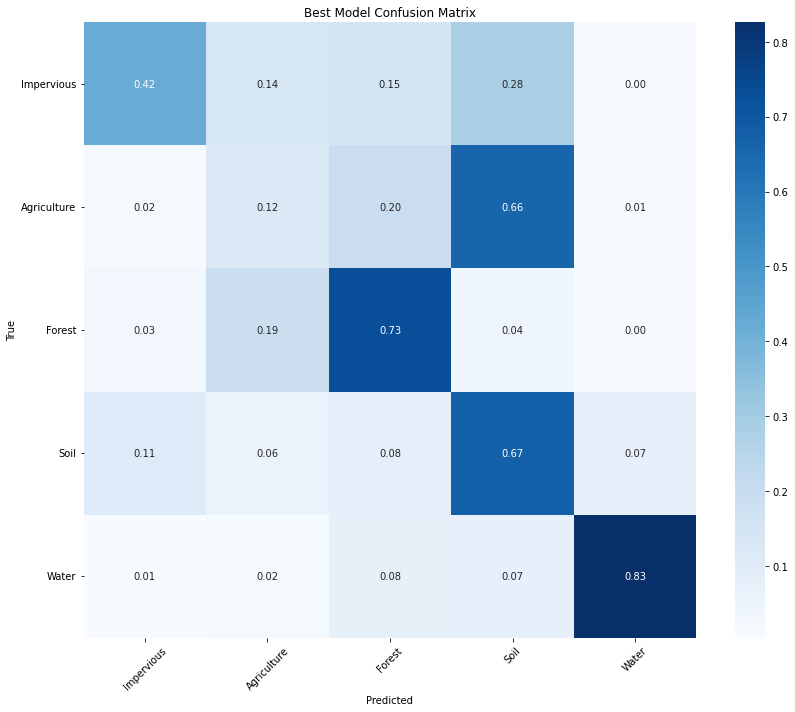

In [95]:
plot_confusion_matrix(
np.array(test_metrics['confusion_matrix']),
class_names=['Impervious', 'Agriculture', 'Forest', 'Soil', 'Water'],
title='Best Model Confusion Matrix'
)